# <center>Group Project 2: Regression and Page Rank</center>
## <center>Josh Melton and Ivan Benitez</center>  

### Part 1: Linear Regression and KNN implementation
#### 1.2) Daily Data
Utilize the same procedure but now with the daily data set.
##### a) Data preparation
First, read the daily bike data csv into a pandas dataframe:
- Set the column names
- Index using the 'instant' column
- Parse the date column

In [1]:
import pandas as pd

daily_data = pd.read_csv('Bike-Sharing-Dataset/day.csv',
                          header=0, index_col=0,
                          parse_dates=[1])
# daily_data.info()

Extract feature set by removing the date column and the label columns.  
Store the column name for each label vector.

In [2]:
features = daily_data.drop(['dteday', 'casual', 'registered', 'cnt'], axis=1)
label_cols = ['casual', 'registered', 'cnt']

##### b) Feature correlation with labels

Calculate the correlation of each feature with the label vectors.  
Plot the four features with the highest correlation with each label vector. 

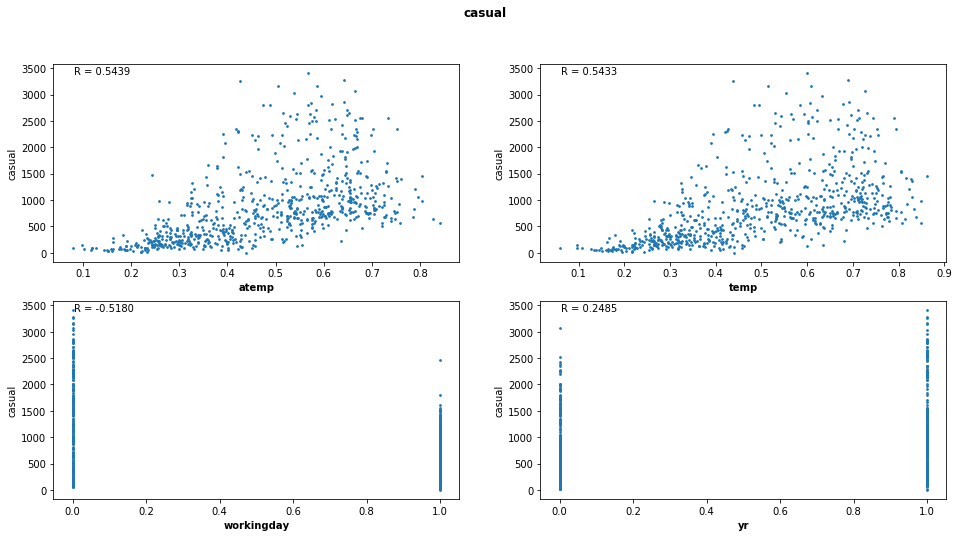

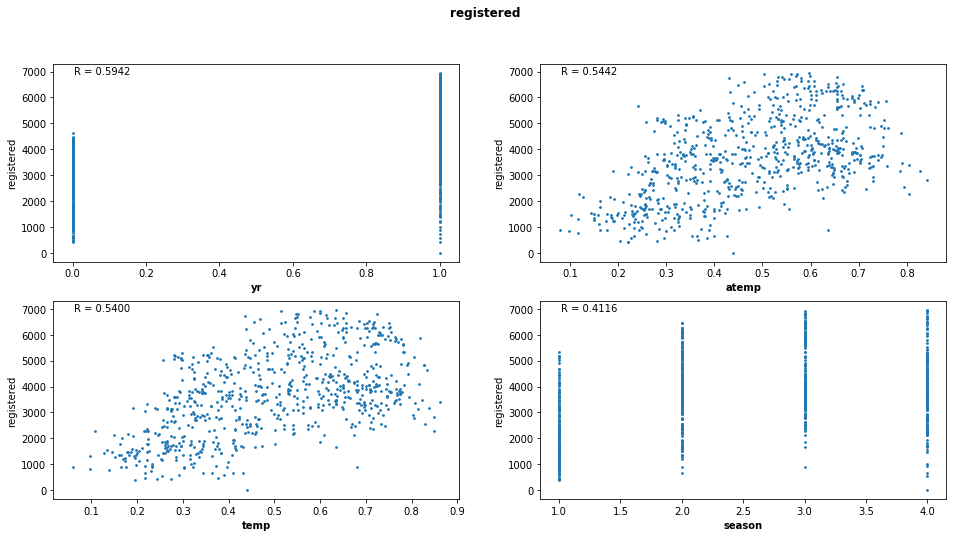

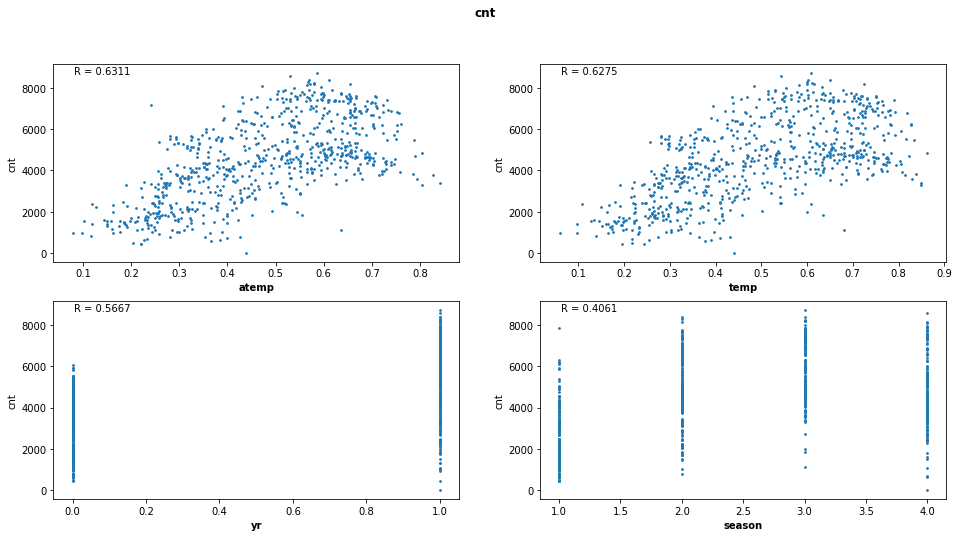

In [6]:
import matplotlib.pyplot as plt

features_subset_cols = []
for lab in label_cols:
    labels = daily_data[lab]

    # Calculate how correlated each feature is with the labels
    corrs = features.corrwith(labels, axis=0,
                              method='pearson')
    # Sort by absolute value of correlation
    order = corrs.abs().sort_values(ascending=False)
    corrs = corrs[order.index]
    # print(corrs)

    # Extract the 5 feature names with highest correlation for each label
    features_subset_cols.append(corrs.index[:5].tolist())
    
    # Plot scatter plot of 4 features with highest correlations
    fig, ax = plt.subplots(2, 2, figsize=(16, 8))
    ind = 0
    for row in [0, 1]:
        for col in [0, 1]:
            df_col = corrs.index[ind]
            ax[row, col].scatter(features[df_col], labels, s=3)

            ax[row, col].set_xlabel(df_col, fontweight='bold')
            ax[row, col].set_ylabel(lab)

            ax[row, col].text(0.05, 0.95, 'R = {:.4f}'.format(corrs[ind]),
                              transform=ax[row, col].transAxes)
            ind += 1
    fig.suptitle(lab, fontweight='bold')
    plt.show()

##### c) Linear Regression Models
Fit linear regression models using:
1. The single most correlated feature with the labels
2. The five features most highly correlated with the labels
3. The entire feature set (11 features)

In [4]:
import math
import sklearn.model_selection as ms
from sklearn import metrics
from sklearn.linear_model import LinearRegression


def print_metrics(y_true, y_preds):
    mse = metrics.mean_squared_error(y_true, y_preds)
    print('\tMean Square Error      = {:.3f}'.format(mse))
    print('\tRoot Mean Square Error = {:.3f}'.format(math.sqrt(mse)))
    print('\tMean Absolute Error    = {:.3f}'.format(metrics.mean_absolute_error(y_true, y_preds)))
    print('\tMedian Absolute Error  = {:.3f}'.format(metrics.median_absolute_error(y_true, y_preds)))
    print('\tR^2                    = {:.3f}'.format(metrics.r2_score(y_true, y_preds)))


string_dict = {0: 'Single most correlated feature:',
               1: 'Five column subset:',
               2: 'Full feature set:'}

print('Linear Regression models:\n')
for i, lab in enumerate(label_cols):
    labels = daily_data[lab]

    best_feature_name = features_subset_cols[i][0]
    best_feature = daily_data[best_feature_name].values.reshape(-1, 1)
    features_subset = daily_data[features_subset_cols[i]]

    print('Label column: {}\n'.format(lab))
    for j, f in enumerate([best_feature, features_subset, features]):
        X_train, X_test, y_train, y_test = ms.train_test_split(f, labels,
                                                               test_size=0.2,
                                                               random_state=123)
        
        print(string_dict[j], best_feature_name) if j == 0 else print(string_dict[j])
        
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)
    
        lin_preds = lin_reg.predict(X_test)
        print_metrics(y_test, lin_preds)
        print()
    print('-' * 50)

Linear Regression models:

Label column: casual

Single most correlated feature: atemp
	Mean Square Error      = 296287.763
	Root Mean Square Error = 544.323
	Mean Absolute Error    = 405.735
	Median Absolute Error  = 308.336
	R^2                    = 0.201

Five column subset:
	Mean Square Error      = 141343.427
	Root Mean Square Error = 375.957
	Mean Absolute Error    = 285.774
	Median Absolute Error  = 231.649
	R^2                    = 0.619

Full feature set:
	Mean Square Error      = 138692.506
	Root Mean Square Error = 372.414
	Mean Absolute Error    = 279.025
	Median Absolute Error  = 210.118
	R^2                    = 0.626

--------------------------------------------------
Label column: registered

Single most correlated feature: yr
	Mean Square Error      = 1393949.052
	Root Mean Square Error = 1180.656
	Mean Absolute Error    = 987.080
	Median Absolute Error  = 890.540
	R^2                    = 0.413

Five column subset:
	Mean Square Error      = 565692.750
	Root Mean Squar

##### c) KNN Regression Models
Fit KNN regression models using:
1. The single most correlated feature with the labels
2. The five features most highly correlated with the labels
3. The entire feature set (11 features)

Use cross validation to determine the best k value for each model, refitting based on the Mean Squared Error.

In [5]:
from sklearn.neighbors import KNeighborsRegressor

import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

print('KNN Regression models:\n')
for i, lab in enumerate(label_cols):
    labels = daily_data[lab]
    
    best_feature_name = features_subset_cols[i][0]
    best_feature = daily_data[best_feature_name].values.reshape(-1, 1)
    features_subset = daily_data[features_subset_cols[i]]

    print('Label column: {}\n'.format(lab))
    for j, f in enumerate([best_feature, features_subset, features]):
        X_train, X_test, y_train, y_test = ms.train_test_split(f, labels,
                                                               test_size=0.2,
                                                               random_state=123)
        
        print(string_dict[j], best_feature_name) if j == 0 else print(string_dict[j])
        
        knn_reg = ms.GridSearchCV(KNeighborsRegressor(),
                                  param_grid={'n_neighbors': range(1, 30, 2)},
                                  cv=5, scoring='neg_mean_squared_error',
                                  refit=True)
        knn_reg.fit(X_train, y_train)
        print('\tBest k:', knn_reg.best_params_)
    
        knn_preds = knn_reg.predict(X_test)
        print_metrics(y_test, knn_preds)
        print()
    print('-' * 50)


KNN Regression models:

Label column: casual

Single most correlated feature: atemp
	Best k: {'n_neighbors': 21}
	Mean Square Error      = 291554.575
	Root Mean Square Error = 539.958
	Mean Absolute Error    = 396.013
	Median Absolute Error  = 308.381
	R^2                    = 0.214

Five column subset:
	Best k: {'n_neighbors': 9}
	Mean Square Error      = 95458.359
	Root Mean Square Error = 308.963
	Mean Absolute Error    = 211.196
	Median Absolute Error  = 149.222
	R^2                    = 0.743

Full feature set:
	Best k: {'n_neighbors': 5}
	Mean Square Error      = 91642.356
	Root Mean Square Error = 302.725
	Mean Absolute Error    = 210.550
	Median Absolute Error  = 148.200
	R^2                    = 0.753

--------------------------------------------------
Label column: registered

Single most correlated feature: yr
	Best k: {'n_neighbors': 29}
	Mean Square Error      = 1409005.116
	Root Mean Square Error = 1187.015
	Mean Absolute Error    = 963.373
	Median Absolute Error  = 836.0